## Set up + Imports 

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black
import yaml
import torch

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


Specify run name

In [2]:
# run_name = "run_tus9d935_s_0=1_sigma_saliency=0.05_x_saliency=0.5"

run_name = "run_smmlsb10_s_0=1_sigma_saliency=0.05_x_saliency=0.5"

In [3]:
import os

base_dir = os.path.join(os.getcwd(), "neuroai/piRNNs/models")
configs_dir = os.path.join(base_dir, "results/configs")
models_dir = os.path.join(base_dir, "results/trained_models")

In [4]:
def _load_expt_config(run_name, configs_dir):
    config_file = os.path.join(configs_dir, f"{run_name}.json")

    with open(config_file) as file:
        return yaml.safe_load(file)

### Load experiment config

In [5]:
expt_config = _load_expt_config(run_name, configs_dir)

In [6]:
import ml_collections


def _d(**kwargs):
    """Helper of creating a config dict."""
    return ml_collections.ConfigDict(initial_dictionary=kwargs)


import ml_collections


def _convert_config(normal_config):
    """Convert a normal dictionary to ml_collections.ConfigDict.

    Parameters
    ----------
    normal_config : dict
        Configuration dictionary.

    Returns
    -------
    ml_collections.ConfigDict
        Converted configuration dictionary.

    """
    config = ml_collections.ConfigDict()

    # Training config
    config.train = {
        "load_pretrain": normal_config["load_pretrain"],
        "pretrain_path": normal_config["pretrain_path"],
        "num_steps_train": normal_config["num_steps_train"],
        "lr": normal_config["lr"],
        "lr_decay_from": normal_config["lr_decay_from"],
        "steps_per_logging": normal_config["steps_per_logging"],
        "steps_per_large_logging": normal_config["steps_per_large_logging"],
        "steps_per_integration": normal_config["steps_per_integration"],
        "norm_v": normal_config["norm_v"],
        "positive_v": normal_config["positive_v"],
        "positive_u": normal_config["positive_u"],
        "optimizer_type": normal_config["optimizer_type"],
    }

    # Simulated data config
    config.data = {
        "max_dr_trans": normal_config["max_dr_trans"],
        "max_dr_isometry": normal_config["max_dr_isometry"],
        "batch_size": normal_config["batch_size"],
        "sigma_data": normal_config["sigma_data"],
        "add_dx_0": normal_config["add_dx_0"],
        "small_int": normal_config["small_int"],
    }

    # Model parameter config
    config.model = {
        "freeze_decoder": normal_config.get("freeze_decoder", False),
        "trans_type": normal_config["trans_type"],
        "rnn_step": normal_config["rnn_step"],
        "num_grid": normal_config["num_grid"],
        "num_neurons": normal_config["num_neurons"],
        "block_size": normal_config["block_size"],
        "sigma": normal_config["sigma"],
        "w_kernel": normal_config["w_kernel"],
        "w_trans": normal_config["w_trans"],
        "w_isometry": normal_config["w_isometry"],
        "w_reg_u": normal_config["w_reg_u"],
        "reg_decay_until": normal_config["reg_decay_until"],
        "adaptive_dr": normal_config["adaptive_dr"],
        "s_0": normal_config["s_0"],
        "x_saliency": normal_config["x_saliency"],
        "sigma_saliency": normal_config["sigma_saliency"],
        "reward_step": normal_config["reward_step"],
        "saliency_type": normal_config["saliency_type"],
    }

    # Path integration config
    config.integration = {
        "n_inte_step": normal_config["n_inte_step"],
        "n_traj": normal_config["n_traj"],
        "n_inte_step_vis": normal_config["n_inte_step_vis"],
        "n_traj_vis": normal_config["n_traj_vis"],
    }

    return config

### Load Trained Model

In [7]:
from neurometry.neuroai.piRNNs.models import model

config = _convert_config(expt_config)
model_config = model.GridCellConfig(**config.model)
device = "cuda"
model = model.GridCell(model_config).to(device)

In [8]:
trained_model_path = os.path.join(models_dir, f"{run_name}_model.pt")
trained_model = torch.load(trained_model_path, map_location=device)
model.load_state_dict(trained_model["state_dict"])

model.eval()

GridCell(
  (encoder): Encoder()
  (decoder): Decoder()
  (trans): TransformNonlinear(
    (nonlinear): ReLU()
  )
)

In [9]:
for name, param in model.named_parameters():
    print(name, param.shape)

encoder.v torch.Size([1800, 40, 40])
decoder.u torch.Size([1800, 40, 40])
trans.A_modules torch.Size([150, 12, 12])
trans.B_modules torch.Size([1800, 2])
trans.b torch.Size([])


In [10]:
A = torch.block_diag(*model.trans.A_modules)

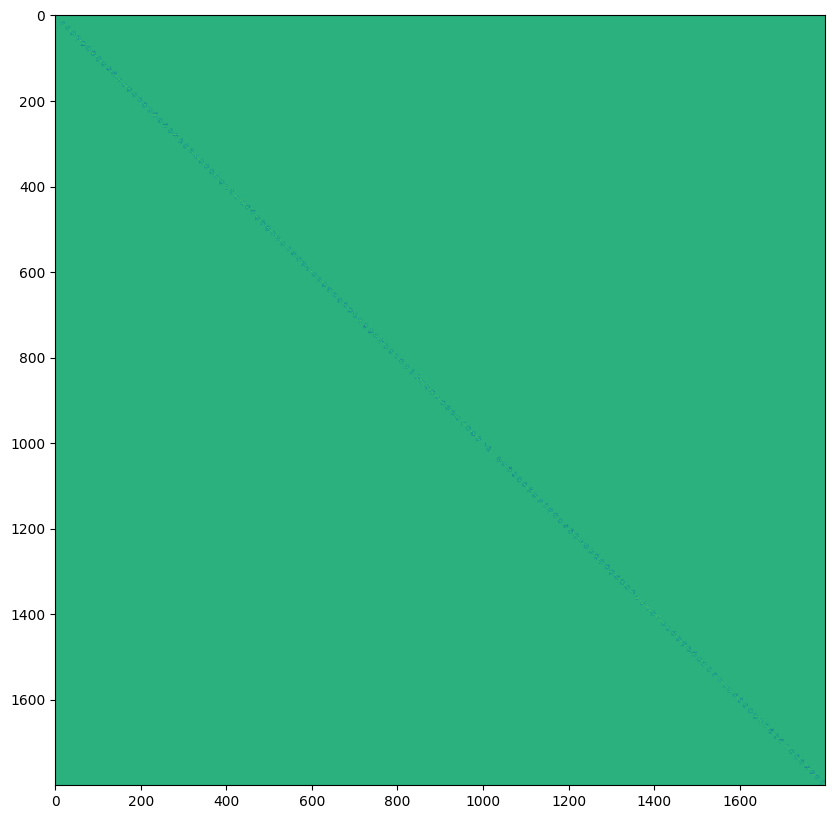

In [11]:
import matplotlib.pyplot as plt

A = A.detach().cpu().numpy()

# visualize A

plt.figure(figsize=(10, 10))
plt.imshow(A, cmap="viridis")

# save figure
plt.savefig("A.png")

### Load evaluation data (trajectories)

In [12]:
config.integration.n_inte_step = 150

print(config.integration)

n_inte_step: 150
n_inte_step_vis: 50
n_traj: 100
n_traj_vis: 5



In [21]:
def print_dict_info(d, indent=0):
    for key, value in d.items():
        print("    " * indent + f"{key}: {type(value).__name__}", end="")
        if isinstance(value, dict):
            print()
            print_dict_info(value, indent + 1)
        elif isinstance(value, np.ndarray):
            print(f" (shape: {value.shape})")
        elif torch.is_tensor(value):
            print(f" (shape: {value.shape})")
        else:
            print()

In [41]:
from neurometry.neuroai.piRNNs.models import input_pipeline
import numpy as np

rng = np.random.default_rng()

config.model.adaptive_dr = True
config.model.block_size = 1800

train_dataset_adapt = input_pipeline.TrainDataset(rng, config.data, config.model)
train_iter_adapt = iter(train_dataset_adapt)
train_batch_adapt = next(train_iter_adapt)
print_dict_info(train_batch_adapt)

kernel: dict
    x: ndarray (shape: (10000, 2))
    x_prime: ndarray (shape: (10000, 2))
trans_rnn: dict
    traj: ndarray (shape: (100, 11, 2))
isometry_adaptive: dict
    x: ndarray (shape: (10000, 1, 2))
    x_plus_dx1: ndarray (shape: (10000, 1, 2))
    x_plus_dx2: ndarray (shape: (10000, 1, 2))


In [ ]:
x_0 = train_batch_adapt["isometry_adaptive"]["x"][:, 0, :]

dx_0 = train_batch_adapt["isometry_adaptive"]["x_plus_dx1"][:, 0, :] - x_0

x_1 = train_batch_adapt["isometry_adaptive"]["x"][:, 1, :]

dx_1 = train_batch_adapt["isometry_adaptive"]["x_plus_dx1"][:, 1, :] - x_1

plt.hist(dx_0.flatten(), bins=100, alpha=0.5, label="dx_0")
plt.hist(dx_1.flatten(), bins=100, alpha=0.5, label="dx_1");

# do the same thing but for multiple index values in a for loop

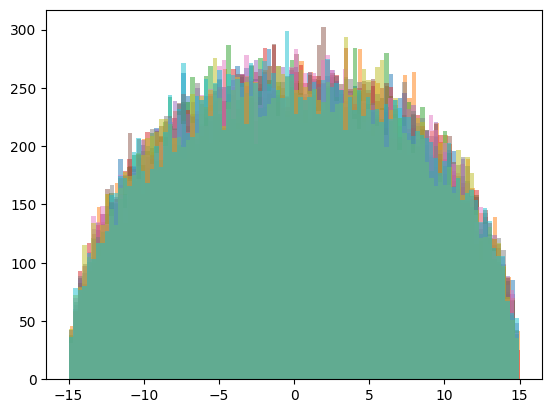

In [38]:
for i in range(10):
    x_i = train_batch_adapt["isometry_adaptive"]["x"][:, 15 * i, :]
    dx_i = train_batch_adapt["isometry_adaptive"]["x_plus_dx1"][:, 15 * i, :] - x_i
    plt.hist(dx_i.flatten(), bins=100, alpha=0.5, label=f"dx_{i}")

In [31]:
train_batch_adapt["isometry_adaptive"]["x"][:, 1, :]

array([[24.52139421, 30.73574212],
       [21.98446523, 14.77544732],
       [13.70410994,  5.45291573],
       ...,
       [25.41605999, 17.8689254 ],
       [ 2.59260532, 12.85095202],
       [12.92990036, 10.48709014]])

In [24]:
config.model.adaptive_dr = False
train_dataset = input_pipeline.TrainDataset(rng, config.data, config.model)
train_iter = iter(train_dataset)
train_batch = next(train_iter)
print_dict_info(train_batch)

kernel: dict
    x: ndarray (shape: (10000, 2))
    x_prime: ndarray (shape: (10000, 2))
trans_rnn: dict
    traj: ndarray (shape: (100, 11, 2))
isometry: dict
    x: ndarray (shape: (10000, 2))
    x_plus_dx1: ndarray (shape: (10000, 2))
    x_plus_dx2: ndarray (shape: (10000, 2))


In [39]:
config.model.num_neurons

1800

In [40]:
config.model.block_size

12

In [163]:
import numpy as np
from neurometry.neuroai.piRNNs.models import input_pipeline
import neurometry.neuroai.piRNNs.models.utils as utils

rng = np.random.default_rng()

eval_dataset = input_pipeline.EvalDataset(
    rng, config.integration, config.data.max_dr_trans, config.model.num_grid
)

eval_iter = iter(eval_dataset)

eval_data = utils.dict_to_device(next(eval_iter), device)

In [164]:
path_integration_output = model.path_integration(eval_data["traj"]["traj"])

err, traj_real, traj_pred, activity, heatmaps = path_integration_output.values()

traj_pred_vanilla = traj_pred["vanilla"]
traj_pred_reencode = traj_pred["reencode"]

traj_real = traj_real.cpu().numpy()
traj_pred_vanilla = traj_pred_vanilla.cpu().numpy()
traj_pred_reencode = traj_pred_reencode.cpu().numpy()

errors = err["err_vanilla"].cpu().numpy()

activity = activity["vanilla"].detach().cpu().numpy()

In [165]:
traj_predicted = traj_pred_vanilla

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

traj_idx = 0

num_trajectories = traj_real.shape[0]
num_steps = traj_real.shape[1]
num_units = activity.shape[2]
max_x = (
    max(np.max(traj_real[traj_idx, :, 0]), np.max(traj_predicted[traj_idx, :, 0])) + 1
)
max_y = (
    max(np.max(traj_real[traj_idx, :, 1]), np.max(traj_predicted[traj_idx, :, 1])) + 1
)

min_x = (
    min(np.min(traj_real[traj_idx, :, 0]), np.min(traj_predicted[traj_idx, :, 0])) - 1
)
min_y = (
    min(np.min(traj_real[traj_idx, :, 1]), np.min(traj_predicted[traj_idx, :, 1])) - 1
)

plt.style.use("ggplot")


def animate(i, traj_idx):
    ax1.cla()  # Clear current plot for trajectory comparison
    ax2.cla()  # Clear current plot for error plot
    ax3.cla()  # Clear current plot for activity plot

    traj_real_single = traj_real[traj_idx]
    traj_pred_single = traj_predicted[traj_idx]

    # Plot real trajectory
    ax1.plot(
        traj_real_single[:i, 0],
        traj_real_single[:i, 1],
        "b-",
        alpha=0.5,
        label="Real Traj",
        linewidth=2,
    )  # Plot trail with reduced opacity
    ax1.plot(
        traj_real_single[i, 0], traj_real_single[i, 1], "bo", markersize=10
    )  # Plot current point

    # Plot predicted trajectory
    ax1.plot(
        traj_pred_single[:i, 0],
        traj_pred_single[:i, 1],
        "r-",
        alpha=0.5,
        label="Pred Traj",
        linewidth=2,
    )  # Plot trail with reduced opacity
    ax1.plot(
        traj_pred_single[i, 0], traj_pred_single[i, 1], "ro", markersize=10
    )  # Plot current point

    ax1.set_xlim(min_x, max_x)  # Adjust x-axis limits as needed
    ax1.set_ylim(min_y, max_y)  # Adjust y-axis limits as needed
    ax1.set_title(
        f"Real vs Predicted Trajectory at Time t={i}", fontsize=16
    )  # Set title for the frame
    ax1.set_xlabel("X Coordinate", fontsize=14)
    ax1.set_ylabel("Y Coordinate", fontsize=14)
    ax1.legend(loc="upper right", fontsize=12)
    ax1.grid(True)

    ax1.annotate(
        "Real",
        xy=(traj_real_single[i, 0], traj_real_single[i, 1]),
        xytext=(5, 5),
        textcoords="offset points",
        color="blue",
    )
    ax1.annotate(
        "Pred",
        xy=(traj_pred_single[i, 0], traj_pred_single[i, 1]),
        xytext=(5, 5),
        textcoords="offset points",
        color="red",
    )

    # Plot the error over time
    ax2.plot(errors[traj_idx, :i], "k-", label="Error")
    ax2.set_xlim(0, num_steps)
    ax2.set_ylim(0, np.max(1.1 * errors[traj_idx, :]))
    ax2.set_title("Error over Time", fontsize=16)
    ax2.set_xlabel("Time Step", fontsize=14)
    ax2.set_ylabel("Error", fontsize=14)
    ax2.grid(True)
    ax2.legend(loc="upper right", fontsize=12)

    # Plot the activity as a heatmap
    activity_single = activity[traj_idx, i, :].reshape(45, -1)
    cax = ax3.imshow(
        activity_single, aspect="auto", cmap="inferno", interpolation="none"
    )
    ax3.set_title(f"Network activity at time t={i}", fontsize=16)
    ax3.grid(False)
    # Turn off the axis labels
    ax3.set_xticks([])
    ax3.set_yticks([])


# Specify which trajectory index you want to visualize
traj_idx_to_visualize = (
    0  # Change this to the index of the trajectory you want to visualize
)

# Set up figure and animation
fig = plt.figure(figsize=(20, 10), dpi=150)
gs = fig.add_gridspec(2, 2, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0, 0])  # Top left
ax3 = fig.add_subplot(gs[0, 1])  # Top right
ax2 = fig.add_subplot(gs[1, :])  # Bottom, spanning both columns

ani = animation.FuncAnimation(
    fig, animate, frames=num_steps, fargs=(traj_idx_to_visualize,), interval=100
)

# Display animation inline in Jupyter Notebook
%matplotlib notebook
HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>

In [167]:
# save animation
ani.save("path_integration.gif", writer="pillow", fps=10)

In [ ]:
from neurometry.dimension.dim_reduction import (
    plot_pca_projections,
    plot_2d_manifold_projections,
)

total_activity = activity.reshape(-1, 1800)
plot_pca_projections(total_activity, total_activity, "", "", 4)
# plot_2d_manifold_projections(total_activity, total_activity)

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

traj_idx = 0

num_trajectories = traj_real.shape[0]
num_steps = traj_real.shape[1]
num_units = activity.shape[2]
max_x = (
    max(np.max(traj_real[traj_idx, :, 0]), np.max(traj_predicted[traj_idx, :, 0])) + 1
)
max_y = (
    max(np.max(traj_real[traj_idx, :, 1]), np.max(traj_predicted[traj_idx, :, 1])) + 1
)

min_x = (
    min(np.min(traj_real[traj_idx, :, 0]), np.min(traj_predicted[traj_idx, :, 0])) - 1
)
min_y = (
    min(np.min(traj_real[traj_idx, :, 1]), np.min(traj_predicted[traj_idx, :, 1])) - 1
)

plt.style.use("ggplot")


def animate(i, traj_idx):
    ax1.cla()  # Clear current plot for trajectory comparison
    ax2.cla()  # Clear current plot for error plot
    ax3.cla()  # Clear current plot for activity plot

    traj_real_single = traj_real[traj_idx]
    traj_pred_single = traj_predicted[traj_idx]

    # Plot real trajectory
    ax1.plot(
        traj_real_single[:i, 0],
        traj_real_single[:i, 1],
        "b-",
        alpha=0.5,
        label="Real Traj",
        linewidth=2,
    )  # Plot trail with reduced opacity
    ax1.plot(
        traj_real_single[i, 0], traj_real_single[i, 1], "bo", markersize=10
    )  # Plot current point

    # Plot predicted trajectory
    ax1.plot(
        traj_pred_single[:i, 0],
        traj_pred_single[:i, 1],
        "r-",
        alpha=0.5,
        label="Pred Traj",
        linewidth=2,
    )  # Plot trail with reduced opacity
    ax1.plot(
        traj_pred_single[i, 0], traj_pred_single[i, 1], "ro", markersize=10
    )  # Plot current point

    ax1.set_xlim(min_x, max_x)  # Adjust x-axis limits as needed
    ax1.set_ylim(min_y, max_y)  # Adjust y-axis limits as needed
    ax1.set_title(
        f"Real vs Predicted Trajectory at Time t={i}", fontsize=16
    )  # Set title for the frame
    ax1.set_xlabel("X Coordinate", fontsize=14)
    ax1.set_ylabel("Y Coordinate", fontsize=14)
    ax1.legend(loc="upper right", fontsize=12)
    ax1.grid(True)

    ax1.annotate(
        "Real",
        xy=(traj_real_single[i, 0], traj_real_single[i, 1]),
        xytext=(5, 5),
        textcoords="offset points",
        color="blue",
    )
    ax1.annotate(
        "Pred",
        xy=(traj_pred_single[i, 0], traj_pred_single[i, 1]),
        xytext=(5, 5),
        textcoords="offset points",
        color="red",
    )

    # Plot the error over time
    ax2.plot(errors[traj_idx, :i], "k-", label="Error")
    ax2.set_xlim(0, num_steps)
    ax2.set_ylim(0, np.max(1.1 * errors[traj_idx, :]))
    ax2.set_title("Error over Time", fontsize=16)
    ax2.set_xlabel("Time Step", fontsize=14)
    ax2.set_ylabel("Error", fontsize=14)
    ax2.grid(True)
    ax2.legend(loc="upper right", fontsize=12)

    # Plot the activity as a heatmap
    activity_single = activity[traj_idx, i, :].reshape(45, -1)
    cax = ax3.imshow(
        activity_single, aspect="auto", cmap="inferno", interpolation="none"
    )
    ax3.set_title(f"Network activity at time t={i}", fontsize=16)
    # ax3.set_xlabel("Time Step", fontsize=14)
    # ax3.set_ylabel("Units", fontsize=14)
    ax3.grid(False)
    # turn off the axis labels
    ax3.set_xticks([])
    ax3.set_yticks([])
    # fig.colorbar(cax, ax=ax3, orientation="vertical")


# Specify which trajectory index you want to visualize
traj_idx_to_visualize = (
    0  # Change this to the index of the trajectory you want to visualize
)

# Set up figure and animation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), dpi=150)
ani = animation.FuncAnimation(
    fig, animate, frames=num_steps, fargs=(traj_idx_to_visualize,), interval=100
)

# Display animation inline in Jupyter Notebook
%matplotlib notebook
HTML(ani.to_html5_video())

IndexError: tuple index out of range

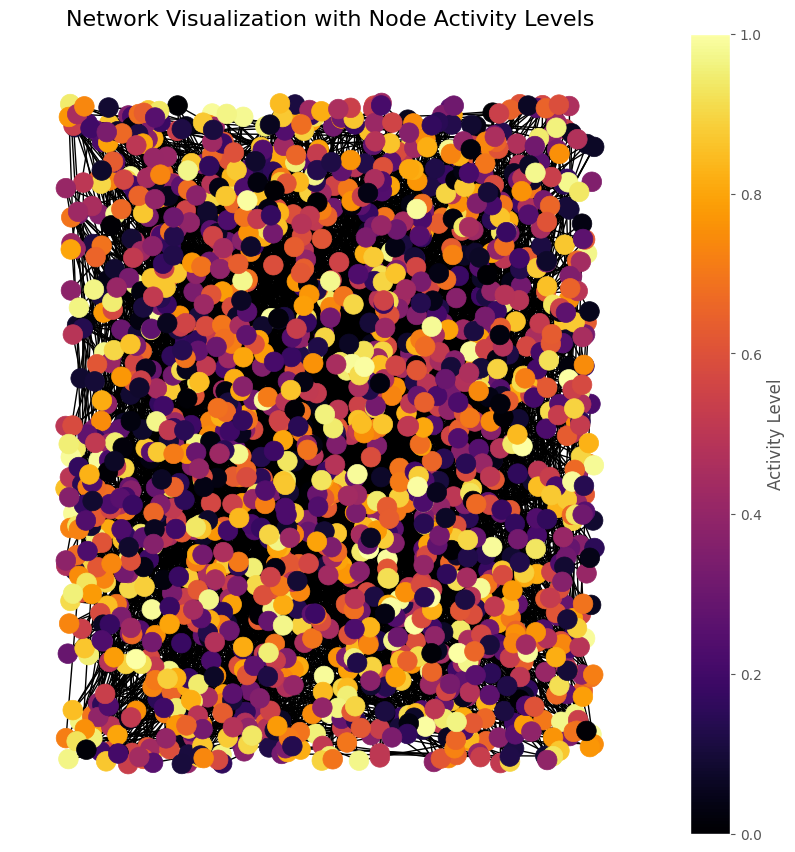

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

# Create a grid graph
G = nx.grid_2d_graph(45, 40)  # Create a 5x5 grid graph

# Generate random activity levels for each node
np.random.seed(42)
activity_levels = np.random.rand(len(G.nodes()))

# Normalize activity levels for color scaling
normalized_activity = activity_levels / np.max(activity_levels)

# Create a position layout for the nodes
# pos = {node: (node[1], -node[0]) for node in G.nodes()}  # Layout in 2D grid form

pos = nx.random_layout(G)

# Draw the graph with node colors representing activity levels
plt.figure(figsize=(8, 8))
nx.draw(
    G,
    pos,
    node_color=normalized_activity,
    node_size=200,
    cmap="inferno",
    with_labels=False,
)
plt.title("Network Visualization with Node Activity Levels", fontsize=16)
plt.colorbar(
    plt.cm.ScalarMappable(cmap="inferno"), ax=plt.gca(), label="Activity Level"
)
plt.show()